In [1]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["./hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model.half()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats,padding_mask):
        inputs = {
            "source": feats,
            "padding_mask": padding_mask,
            "output_layer": 12
        }
        return self.model.extract_features(**inputs)

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt")
padding_mask = torch.load("./padding_mask.pt")

2025-02-19 06:39:01 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2025-02-19 06:39:02 | INFO | fairseq.tasks.hubert_pretraining | current directory is /root/Testing
2025-02-19 06:39:02 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2025-02-19 06:39:02 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'ac

In [2]:
adapter = HuberAdapter(hubert_model.cuda())

In [3]:
output = adapter(feats,padding_mask)

In [4]:
output[0].shape

torch.Size([1, 100, 768])

In [5]:
output[1].shape

torch.Size([1, 100])

In [6]:
output[0]

tensor([[[-0.0991, -0.0463,  0.1193,  ..., -0.1276,  0.0782,  0.0181],
         [-0.1157, -0.1154, -0.2700,  ...,  0.0246, -0.0500,  0.1478],
         [ 0.0127,  0.0363, -0.1959,  ..., -0.0300, -0.1183,  0.0363],
         ...,
         [-0.0409,  0.1770,  0.2234,  ...,  0.0162,  0.3916,  0.1497],
         [-0.0822,  0.1790,  0.0260,  ...,  0.4600,  0.4241,  0.2003],
         [ 0.0465, -0.0415, -0.1802,  ..., -0.0035, -0.0467, -0.1370]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<TransposeBackward0>)

关于下面使用的ONNX模型，可前往Xenova的[HuggingFace仓库](https://huggingface.co/Xenova/hubert-base-ls960)克隆，或使用HuggingFace CLI下载

In [14]:
import onnxruntime as ort

model = ort.InferenceSession("./model_quantized.onnx",providers=["CUDAExecutionProvider"])

2025-02-19 06:41:45.237550458 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 195 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-02-19 06:41:45.245407483 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-02-19 06:41:45.245425614 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [17]:
from time import perf_counter

In [18]:
start = perf_counter()
output_onnx = model.run(
    ["last_hidden_state"],
    {"input_values":feats.float().cpu().numpy()}
)[0]
end = perf_counter()
print(f"Infer cost on GPU Quantized ONNX: {round(end-start,2)} seconds")

Infer cost on GPU Quantized ONNX: 0.77 seconds


In [19]:
output_onnx.shape

(1, 100, 768)

In [20]:
import numpy as np

In [24]:
np.array(output_onnx.flat)

array([-0.13810822,  0.1003557 , -0.04363701, ..., -0.414043  ,
       -0.14644362,  1.4216685 ], dtype=float32)

In [25]:
output[0].flatten()

tensor([-0.0991, -0.0463,  0.1193,  ..., -0.0035, -0.0467, -0.1370],
       device='cuda:0', dtype=torch.float16, grad_fn=<ReshapeAliasBackward0>)

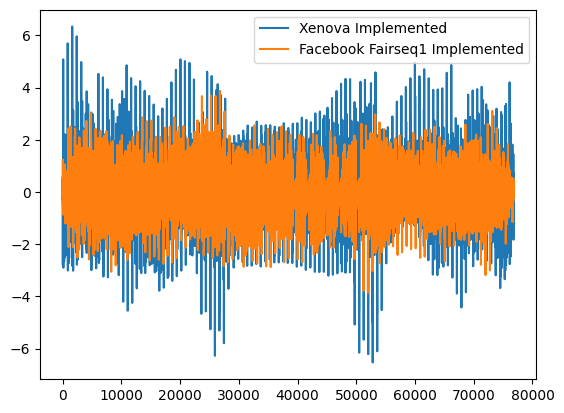

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.array(output_onnx.flat),label="Xenova Implemented")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="Facebook Fairseq1 Implemented")
plt.legend()
plt.savefig("output.png",dpi=300)
plt.show()

In [32]:
print(f"Bound of Xenova Implemented: min {min(np.array(output_onnx.flat))},max {max(np.array(output_onnx.flat))}.")
print(f"Bound of Fairseq1 Implemented: min {min(output[0].flatten())},max {max(output[0].flatten())}.")

Bound of Xenova Implemented: min -6.532502174377441,max 6.341852188110352.
Bound of Fairseq1 Implemented: min -3.859375,max 3.873046875.
